# Importance sampling: toy example with parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(32768, 3, 1, 1), ratio=0.5):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size) + 0.2 # to make light gray
    image_batch[idx] = 1 - 0.2 # to make light gray 
    return image_batch

The dataset class

In [13]:
class BlackWhiteDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, weight_network):
        self.dataset = random_image_data()
        
        self.weight_network = weight_network

    def __len__(self):
        return len(self.dataset)
    
    def accept_sample(self, weight_network, img):
        # Returns True if the image is accepted, False if rejected
        weight = weight_network(img)
        return bool(list(torch.utils.data.sampler.WeightedRandomSampler([1-weight, weight], 1))[0])
    
    def __getitem__(self, idx):
        # Random permutation on the dataset order (is this equivalent to uniform sampling?)
        all_idx = torch.randperm(len(dataset))
        
        # Loop through the samples and return once accepted
        for i in all_idx:
            accept = self.accept_sample(self.weight_network, self.dataset[i])
            if accept:
                return self.dataset[i]

The weight network with parameters

In [36]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
        self.fc1.weight.data.fill_(0.5) # This as initialization because when the weights are too small
        self.fc2.weight.data.fill_(0.5) # no images are sampled

    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

weight_network = Net()

In [37]:
dataset = BlackWhiteDataset(weight_network)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [31]:
example_img = torch.cat((torch.Tensor([0.2, 0.2, 0.2]), torch.Tensor([0.8, 0.8, 0.8])))
w = weight_network(example_img)
print(w)

tensor([[0.4107],
        [0.4367]], grad_fn=<SigmoidBackward>)


Training loop with MSE

In [42]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(weight_network.parameters(), lr=0.00001)

In [43]:
# for i, data in enumerate(dataloader):
#     labels = data.mean(1).view(-1, 1)
    
#     optimizer.zero_grad()

#     # forward + backward + optimize
#     outputs = weight_network(data)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

#     # print statistics
#     if i % 50 == 0:
#         print('step', i, 'loss: ', loss.item())
# #         print('outputs:', outputs[0].item(), 'labels:', labels[0].item())
# #         print()

With Helge's objective function

In [44]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
for i, data in enumerate(dataloader):
#     labels = data.mean(1).view(-1, 1)

    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = weight_network(data)
    
    # Ground truth:
    ground_truth = data.mean(1).view(-1, 1) 
    
    loss = ( (data.mean(1).view(-1, 1)-0.5) * (outputs/outputs.detach()).view(-1, 1)).sum()
    
    loss.backward()
    optimizer.step()

    # print statistics
    if i % 50 == 0:
        
        w = weight_network(example_img)
        print('step', i, 'loss: ', loss.item())
        print('outputs:', w[0].item(), w[1].item(), 'ground_truth', example_img[0].item(), example_img[3].item())
        print()

step 0 loss:  -1.2000000476837158
outputs: 0.7748978137969971 0.7909761071205139 ground_truth 0.20000000298023224 0.800000011920929

step 50 loss:  -1.8000000715255737
outputs: 0.7748932838439941 0.7909656167030334 ground_truth 0.20000000298023224 0.800000011920929

step 100 loss:  0.6000000238418579
outputs: 0.7748880386352539 0.7909545302391052 ground_truth 0.20000000298023224 0.800000011920929

step 150 loss:  1.2000000476837158
outputs: 0.7748895883560181 0.7909502387046814 ground_truth 0.20000000298023224 0.800000011920929

step 200 loss:  3.0
outputs: 0.7748900651931763 0.7909450531005859 ground_truth 0.20000000298023224 0.800000011920929

step 250 loss:  1.2000000476837158
outputs: 0.7748743295669556 0.7909229397773743 ground_truth 0.20000000298023224 0.800000011920929

step 300 loss:  -0.6000000238418579
outputs: 0.774872899055481 0.7909157276153564 ground_truth 0.20000000298023224 0.800000011920929

step 350 loss:  3.5999999046325684
outputs: 0.7748581171035767 0.7908946275711

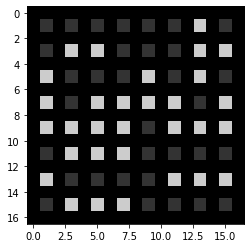

light grey = 0.2, dark grey = 0.8


In [41]:
visualize_img_batch(data)
print('light grey = 0.2, dark grey = 0.8')